In [ ]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

d:\Users\amirh\anaconda3\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


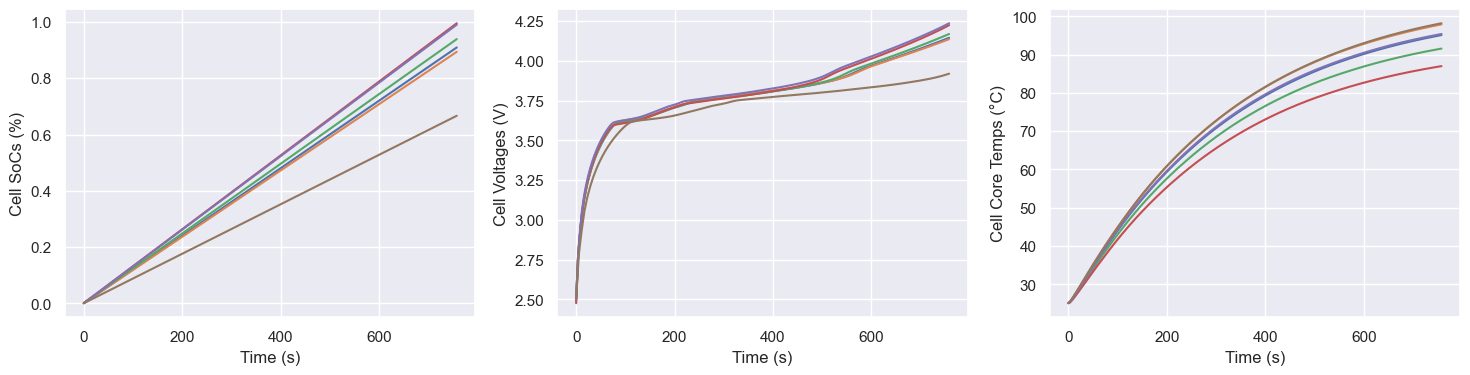

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
from LIBEnv.LIB_gym_no_temp import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_switch=False)

pack_res=[]
rewards = []
env.reset(0)[0].reshape(3,6)
env.pack.ECM.z_k = np.zeros((1,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(6))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('Time (s)')
plt.ylabel('Cell SoCs (%)')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.xlabel('Time (s)')
plt.ylabel('Cell Voltages (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:]*env.T)
plt.xlabel('Time (s)')
plt.ylabel('Cell Core Temps (°C)')
plt.grid('on')

### Tensorboard 

In [ ]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

# stable baseline3

In [2]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
  def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
    super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
    self.check_freq = check_freq
    self.log_dir = log_dir
    self.save_path = os.path.join(log_dir, "best_model")
    self.best_mean_reward = -np.inf

  def _init_callback(self) -> None:
    pass

  def _on_step(self) -> bool:
    if self.n_calls % self.check_freq == 0:
      # Retrieve training reward
      results = pd.read_csv(os.path.join(self.log_dir, "monitor.csv"))
      returns = np.array(results.iloc[:,0].astype(float)).ravel()
      mean_reward = np.mean(returns[-100:])
      if len(returns) > 0:
        # Mean training reward over the last 100 episodes
        if self.verbose >= 1:
          print(f"Num timesteps: {self.num_timesteps}")
          print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

        # New best model, you could save the agent here
        if mean_reward > self.best_mean_reward:
          self.best_mean_reward = mean_reward
          # Example for saving best model
          if self.verbose >= 1:
            print(f"Saving new best model to {self.save_path}")
          self.model.save(self.save_path)
      return True

d:\Users\amirh\anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [3]:
from stable_baselines3 import PPO, DDPG, A2C, TD3, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import os

timesteps = 5e7
log_dir = "./training_record__no_temp/"

check_env(env, warn=True)
env = Monitor(env, log_dir+'monitor.csv', override_existing=False)
model = SAC("MlpPolicy", env, verbose=1,
            tensorboard_log=log_dir,
            learning_rate=1e-3,
            # buffer_size=int(1e6),
            # batch_size=1024,
            gamma=0.95,
            # tau=0.05,
            policy_kwargs=dict(net_arch=[32, 32, 32]))

best_cb = SaveOnBestTrainingRewardCallback(check_freq=2e4, log_dir=log_dir)
checkpoint_cb = CheckpointCallback(save_freq=5e4, save_path=log_dir+'checkpoints', name_prefix='battery_rl_model')

# Train the agent
# model = model.load('best_model.zip', env)
model = model.load(f'{log_dir}/checkpoints/battery_rl_model_11600000_steps', env, custom_objects={'observation_space': env.observation_space, 'action_space': env.action_space}) 
model.learn(total_timesteps=timesteps, callback=[best_cb, checkpoint_cb], progress_bar=False)

d:\Users\amirh\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:422: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.


In [4]:
model.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (latent_pi): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
  )
  (mu): Linear(in_features=32, out_features=6, bias=True)
  (log_std): Linear(in_features=32, out_features=6, bias=True)
)

In [5]:
model.critic

ContinuousCritic(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (qf0): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (qf1): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# run from here 3 blocks

(-30000.0, 0.0)

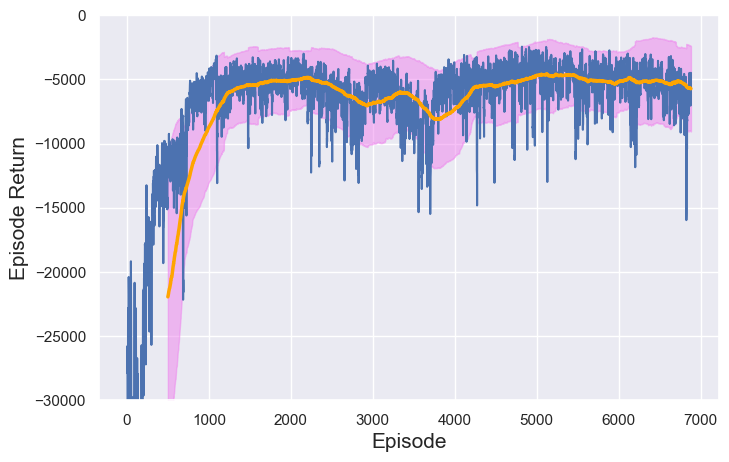

In [6]:
import pandas as pd
results = pd.read_csv(f'./{log_dir}/monitor.csv')
returns = np.array(results.iloc[:12000,0].astype(float)).ravel()

window = 500
rolling_mean_small = pd.Series(returns).rolling(5).mean()
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(rolling_mean_small)
plt.plot(rolling_mean, color='orange', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Episode Return', fontsize=15)
plt.grid('on')
plt.ylim([-30000,0])

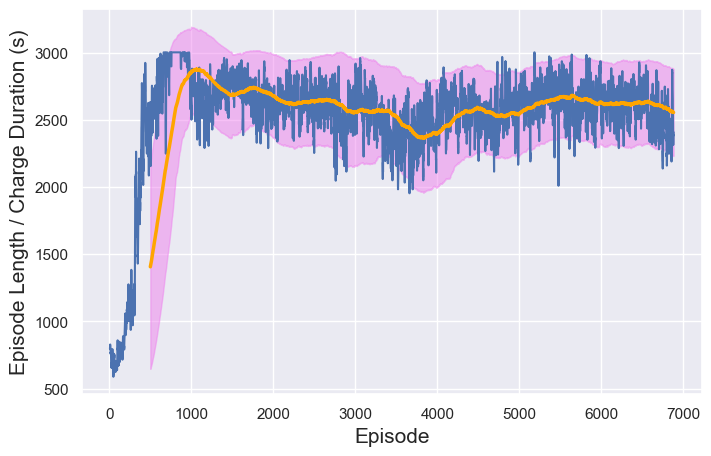

In [7]:
import pandas as pd
results = pd.read_csv(f'./{log_dir}/monitor.csv')
returns = np.array(results.iloc[:12000,1].astype(float)).ravel()

window = 500
rolling_mean_small = pd.Series(returns).rolling(7).mean()
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(rolling_mean_small)
plt.plot(rolling_mean, color='orange', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Episode Length / Charge Duration (s)', fontsize=15)
plt.grid('on')
# plt.ylim([1000,2000])

Wrapping the env in a DummyVecEnv.
-2889.6191 41.16919 0.03915061


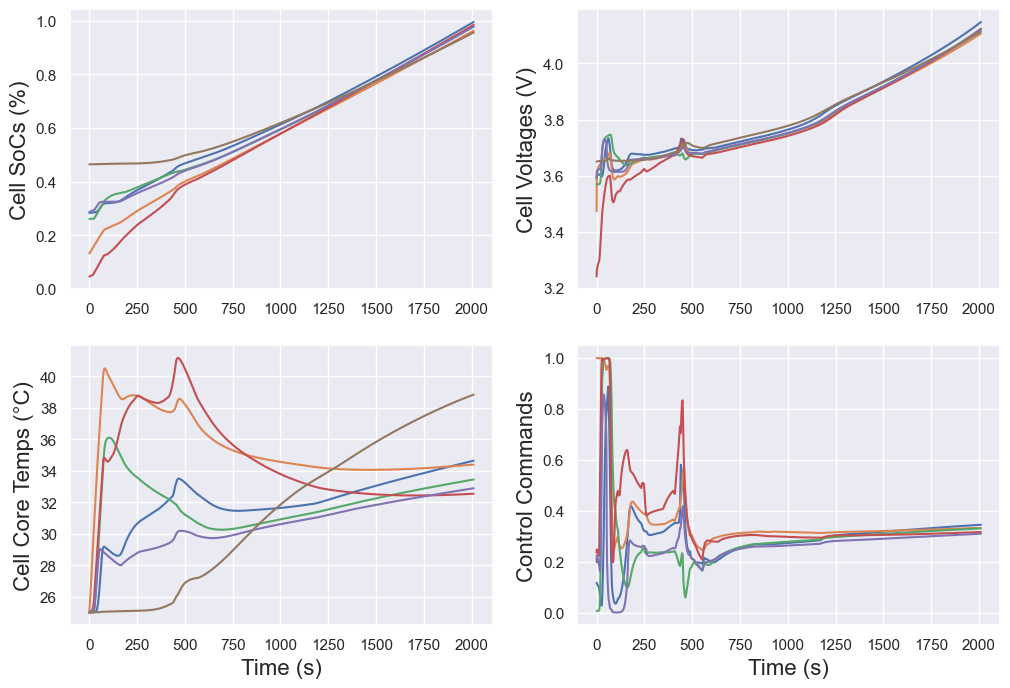

In [9]:
# model = model.load(f'{log_dir}/checkpoints/battery_rl_model_27200000_steps', env, custom_objects={'observation_space': env.observation_space, 'action_space': env.action_space}) 
model = model.load(f'{log_dir}/best_model', env, custom_objects={'observation_space': env.observation_space, 'action_space': env.action_space})

vec_env = model.get_env()
vec_env.seed(0)
state = vec_env.reset()

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action, _states = model.predict(state, deterministic=True)
    # action[..., -1] = 0.15
    next_state, reward, done, info = vec_env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)

print(np.sum(rewards), np.max(pack_res[:-1,2,:]*env.T), np.mean(np.max(pack_res[600:-1,0,:],axis=-1)-np.min(pack_res[600:-1,0,:],axis=-1)))
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('Cell SoCs (%)', fontsize=16)
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.ylabel('Cell Voltages (V)', fontsize=16)
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:]*env.T)
plt.ylabel('Cell Core Temps (°C)', fontsize=16)
plt.xlabel('Time (s)', fontsize='16')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6)[:,:-1])
# plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,-1], "--", color='red')
plt.ylabel('Control Commands', fontsize=16)
plt.xlabel('Time (s)', fontsize='16')
plt.grid('on')

### Find the best model

In [192]:
soc_max = 1
for i in os.listdir(f'{log_dir}/checkpoints'):
    model = model.load(f'{log_dir}/checkpoints/{i}', env) 
    # 34750000 34250000
    # model = model.load(f'{log_dir}/best_model', env)

    vec_env = model.get_env()
    vec_env.seed(0)
    state = vec_env.reset()

    pack_res=[]
    rewards = []
    actions = []

    done = False
    pack_res.append(state.reshape(3,6))
    while not done:
        action, _states = model.predict(state, deterministic=True)
        next_state, reward, done, info = vec_env.step(action)
        state = next_state
        pack_res.append(next_state.reshape(3,6))
        rewards.append(reward)
        actions.append(action)

    pack_res = np.array(pack_res)

    print(np.sum(rewards), np.max(pack_res[:-1,2,:]*env.T), np.mean(np.max(pack_res[600:-1,0,:],axis=-1)-np.min(pack_res[600:-1,0,:],axis=-1)), soc_max)
    if np.mean(np.max(pack_res[600:-1,0,:],axis=-1)-np.min(pack_res[600:-1,0,:],axis=-1))< soc_max:
        soc_max = np.mean(np.max(pack_res[600:-1,0,:],axis=-1)-np.min(pack_res[600:-1,0,:],axis=-1))
        imax = i

soc_max, imax

Wrapping the env in a DummyVecEnv.
-1457.343 40.43799 0.031725984 1
Wrapping the env in a DummyVecEnv.
-4580.824 34.402992 0.1470319 0.031725984
Wrapping the env in a DummyVecEnv.
-9107.202 62.59107 0.61093557 0.031725984
Wrapping the env in a DummyVecEnv.
-1422.0007 40.717453 0.042769168 0.031725984
Wrapping the env in a DummyVecEnv.
-1756.404 40.852818 0.044711743 0.031725984
Wrapping the env in a DummyVecEnv.
-1338.2627 40.033066 0.03545275 0.031725984
Wrapping the env in a DummyVecEnv.
-1478.9271 40.370155 0.022108028 0.031725984
Wrapping the env in a DummyVecEnv.
-2155.7053 42.37226 0.032586426 0.022108028
Wrapping the env in a DummyVecEnv.
-1861.9717 42.05008 0.036528792 0.022108028
Wrapping the env in a DummyVecEnv.
-1551.3433 41.268898 0.03891138 0.022108028
Wrapping the env in a DummyVecEnv.
-2057.401 41.093216 0.04454692 0.022108028
Wrapping the env in a DummyVecEnv.
-2162.5107 39.32149 0.06890613 0.022108028
Wrapping the env in a DummyVecEnv.
-1696.7749 40.910416 0.041379176

In [14]:
np.array(actions)[:-1].shape

(1433, 1, 7)

(0.0, 0.2)

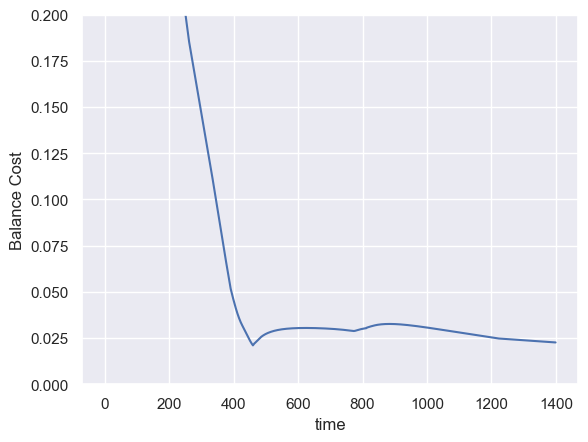

In [24]:
plt.plot(np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1)).sum(-1))
plt.xlabel('time')
plt.ylabel('Balance Cost')
plt.grid('on')
plt.ylim([0,0.2])

(0.0, 0.2)

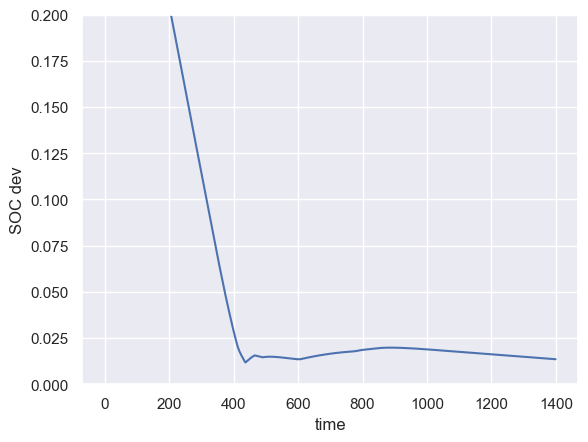

In [25]:
plt.plot(pack_res[:-1,0,:].max(-1) - pack_res[:-1,0,:].min(-1))
plt.xlabel('time')
plt.ylabel('SOC dev')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
model.save('./last_model.pth')

# SoC Plot

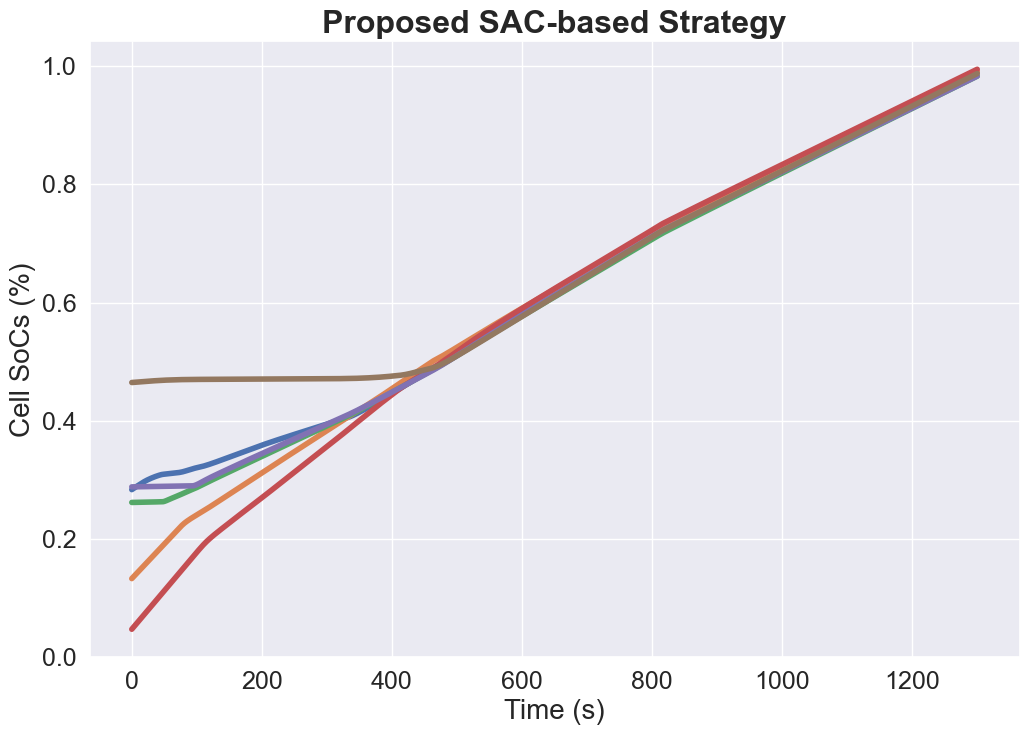

In [9]:
import matplotlib

plt.figure(figsize=(12,8))
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
plt.plot(pack_res[:-1,0,:], linewidth=4)
plt.ylabel('Cell SoCs (%)', fontsize='20')
plt.xlabel('Time (s)', fontsize='20')
plt.title('Proposed SAC-based Strategy', fontsize='23', weight='bold')
plt.grid('on')


(0.4, 0.6)

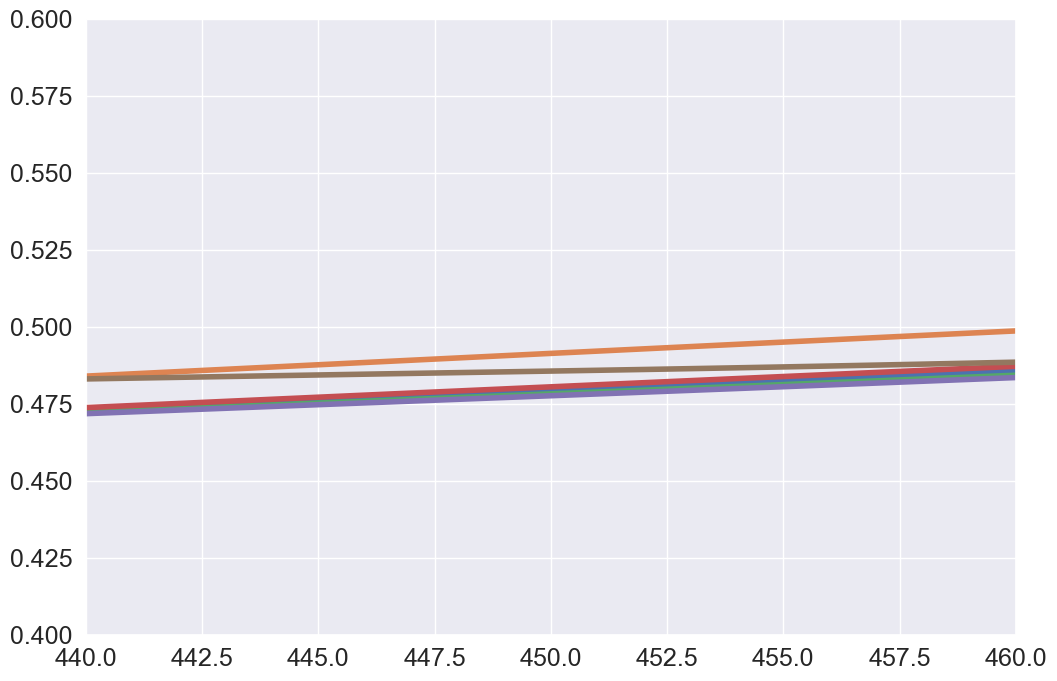

In [10]:
plt.figure(figsize=(12,8))
plt.plot(pack_res[:-1,0,:], linewidth=4)
plt.xlim([440, 460])
plt.ylim([0.4,0.6])

In [11]:
len(pack_res[:-1,0,:])

1301

# Tianshu

In [ ]:
pip install tianshou

In [ ]:
import gymnasium as gym
import torch, numpy as np, torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts

In [ ]:
lr, epoch, batch_size = 1e-3, 10, 64
train_num, test_num = 10, 100
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 10000, 10
logger = ts.utils.TensorboardLogger(SummaryWriter('log/dqn'))  # TensorBoard is supported!
# For other loggers: https://tianshou.readthedocs.io/en/master/tutorials/logger.html